In [23]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [24]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Processing

In [25]:
# Load data
with open("friends_train.json", "r") as file:
    train_data = json.load(file)
with open("friends_test.json", "r") as file:
    test_data = json.load(file)
with open("friends_dev.json", "r") as file:
    dev_data = json.load(file)

In [26]:
# Creating train Dataset
combined_data = [entry for sublist in train_data for entry in sublist]
utterance_emotion_data = [{'utterance': entry['utterance'], 'emotion': entry['emotion']} for entry in combined_data]
df_train = pd.DataFrame(utterance_emotion_data)
df_train.head()

,utterance,emotion
0,also I was the point person on my companys tr...,neutral
1,You mustve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So lets talk a little bit about your duties.,neutral
4,My duties? All right.,surprise


In [28]:
# Creating Dev Dataset
combined_data = [entry for sublist in dev_data for entry in sublist]
utterance_emotion_data = [{'utterance': entry['utterance'], 'emotion': entry['emotion']} for entry in combined_data]
df_dev = pd.DataFrame(utterance_emotion_data)
df_dev.head()

,utterance,emotion
0,"Oh my God, hes lost it. Hes totally lost it.",non-neutral
1,What?,surprise
2,"Or! Or, we could go to the bank, close our acc...",neutral
3,Youre a genius!,joy
4,"Aww, man, now we wont be bank buddies!",sadness


In [27]:
# Creating test Dataset
combined_data = [entry for sublist in test_data for entry in sublist]
utterance_emotion_data = [{'utterance': entry['utterance'], 'emotion': entry['emotion']} for entry in combined_data]
df_test = pd.DataFrame(utterance_emotion_data)
df_test.head()

,utterance,emotion
0,Why do all youre coffee mugs have numbers on ...,surprise
1,Oh. Thats so Monica can keep track. That way ...,non-neutral
2,Y'know what?,neutral
3,It didnt.,neutral
4,"Okay, so what you used to have with Rachel, is...",joy


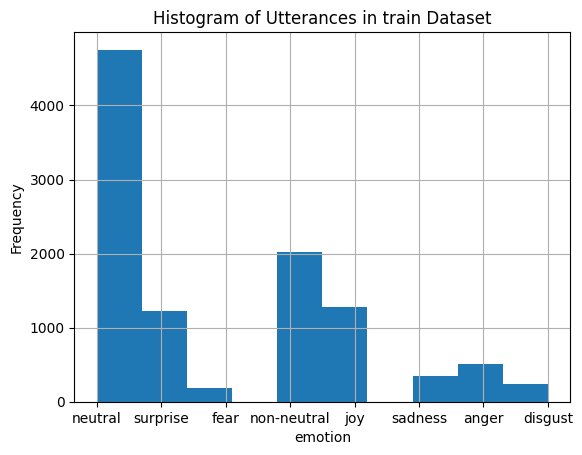

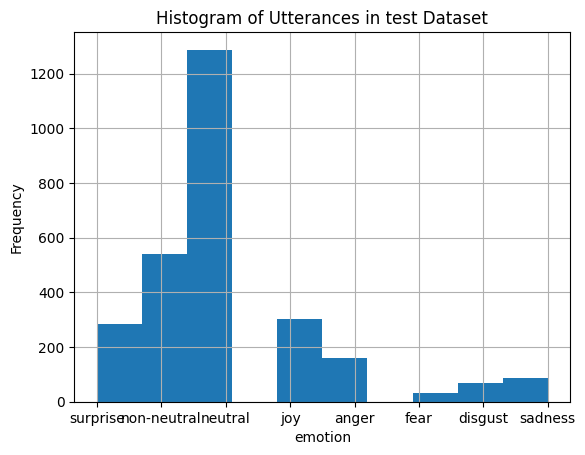

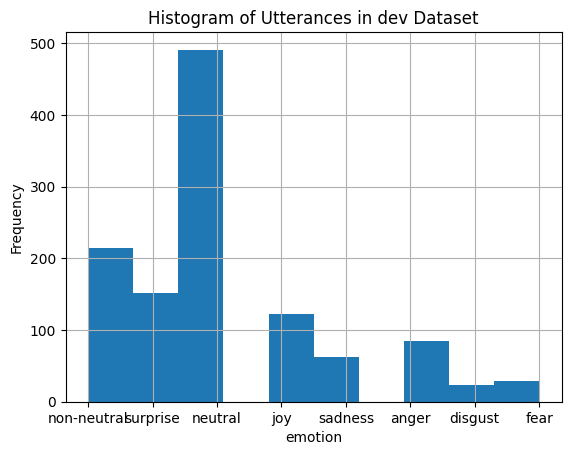

In [29]:
# Creating Histograms of emotions
data = [df_train,df_test,df_dev]
for df, name in zip(data, ['train', 'test', 'dev']):
    plt.figure()
    df['emotion'].hist()
    plt.xlabel('emotion')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Utterances in {name} Dataset')
    plt.show()

In [30]:
# Creating function to process text
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return " ".join(tokens)

In [31]:
# Processing text
for df in data:
    df['preprocessed_utterance'] = df['utterance'].apply(preprocess_text)

In [32]:
# Vectorize Data
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(df_train['preprocessed_utterance'])
tfidf_test = tfidf_vectorizer.transform(df_test['preprocessed_utterance'])
tfidf_dev = tfidf_vectorizer.transform(df_dev['preprocessed_utterance'])

## SVM Model

Best Parameters found:
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Score:
0.4927567350026531

Classification Report on Dev Set:
              precision    recall  f1-score   support

       anger       1.00      0.00      0.00        85
     disgust       1.00      0.04      0.08        23
        fear       0.50      0.03      0.06        29
         joy       0.55      0.20      0.29       123
     neutral       0.47      0.96      0.63       491
 non-neutral       0.24      0.07      0.11       214
     sadness       0.64      0.11      0.19        62
    surprise       0.54      0.17      0.25       151

    accuracy                           0.46      1178
   macro avg       0.62      0.20      0.20      1178
weighted avg       0.50      0.46      0.36      1178



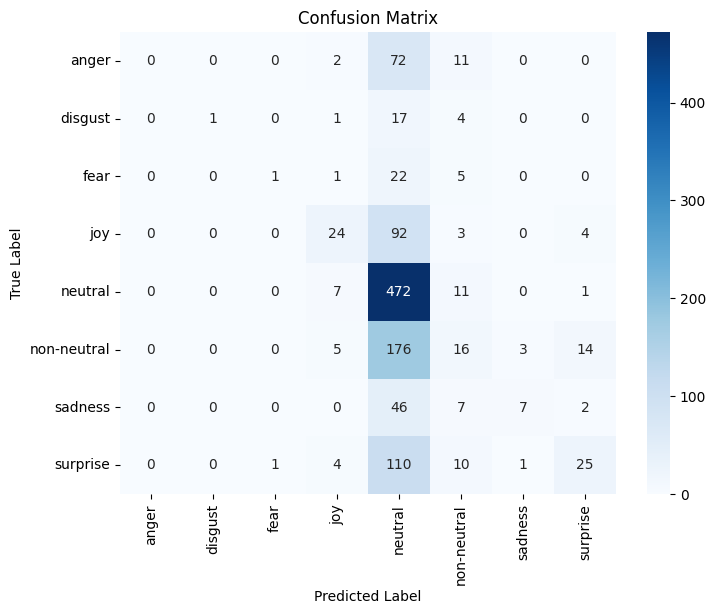

In [33]:
# Construct SVM classifier
svm_classifier = SVC()

# Define hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['linear', 'poly', 'rbf']
}

# Perform grid search to find the best model
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5)
grid_search.fit(tfidf_train, df_train['emotion'])

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters found:")
print(best_params)
print("Best Score:")
print(best_score)

# Get the best model
best_svm_model = grid_search.best_estimator_

# Predict on dev set
dev_predictions = best_svm_model.predict(tfidf_dev)

# Compute classification metrics
print("\nClassification Report on Dev Set:")
print(classification_report(df_dev['emotion'], dev_predictions, zero_division=1))

# Compute confusion matrix
conf_matrix = confusion_matrix(df_dev['emotion'], dev_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_svm_model.classes_, yticklabels=best_svm_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Classification Report on test Set:
              precision    recall  f1-score   support

       anger       0.40      0.01      0.02       161
     disgust       0.67      0.06      0.11        68
        fear       0.50      0.03      0.06        32
         joy       0.56      0.18      0.28       304
     neutral       0.51      0.93      0.66      1287
 non-neutral       0.30      0.10      0.15       541
     sadness       0.71      0.12      0.20        85
    surprise       0.65      0.21      0.32       286

    accuracy                           0.50      2764
   macro avg       0.54      0.21      0.22      2764
weighted avg       0.49      0.50      0.41      2764



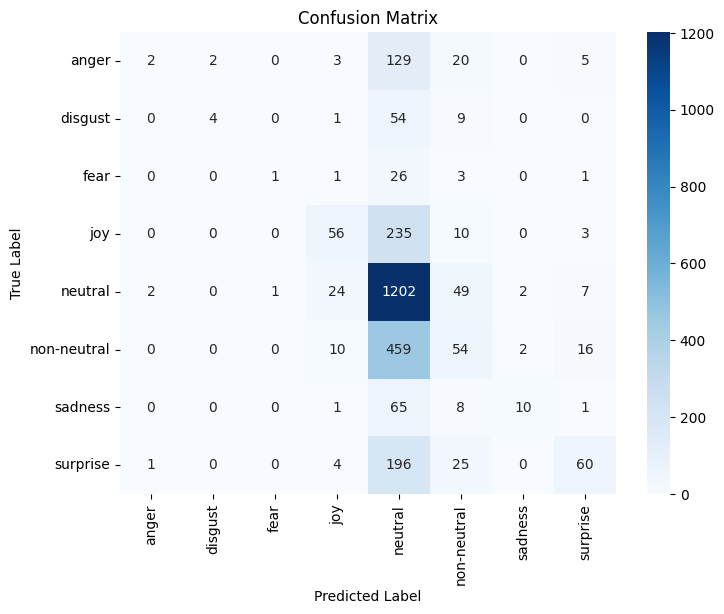

In [34]:
# Predict on test set
test_predictions = best_svm_model.predict(tfidf_test)
print("Classification Report on test Set:")
print(classification_report(df_test['emotion'], test_predictions))
# Compute confusion matrix
conf_matrix = confusion_matrix(df_test['emotion'], test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_svm_model.classes_, yticklabels=best_svm_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## K-Means Model

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Best parameters found:
{'init': 'k-means++', 'max_iter': 500, 'n_clusters': 8}


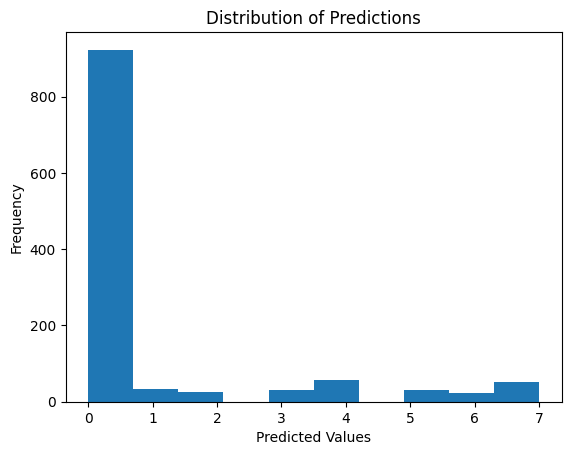

In [35]:
# Model
kmeans = KMeans()

# Define the parameters grid to search
param_grid = {
    'n_clusters': [2, 4, 8],
    'init': ['k-means++', 'random'],
    'max_iter': [300, 500],
}

# Initialize GridSearchCV
grid_search_KNN = GridSearchCV(kmeans, param_grid, cv=3, n_jobs=-1)

# Fit the grid search to the data
grid_search_KNN.fit(tfidf_train)

# Print the best parameters and best score
print("Best parameters found:")
print(grid_search_KNN.best_params_)

# Get the best model
best_model = grid_search_KNN.best_estimator_

# Best model for predictions
dev_predictions_KNN = best_model.predict(tfidf_dev)
test_predictions_KNN = best_model.predict(tfidf_test)
plt.hist(dev_predictions_KNN, bins=10)
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.show()

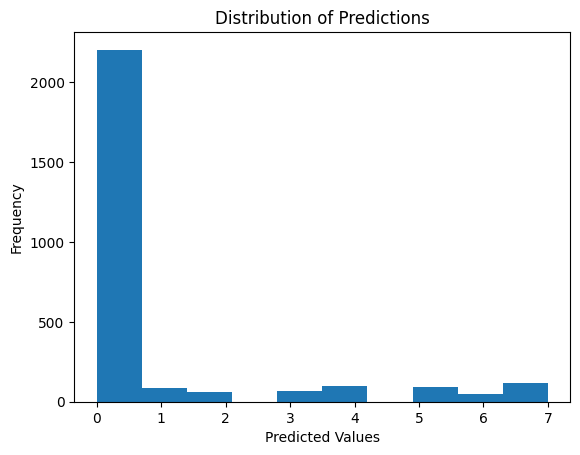

In [36]:
# Best model for predictions on the test data
test_predictions_KNN = best_model.predict(tfidf_test)
plt.hist(test_predictions_KNN, bins=10)
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.show()